## Data Preprocessing

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import sentencepiece as spm
import scienceplots
import pandas as pd
from rdkit import Chem
plt.rcParams.update( {'text.usetex' : True,
                    'font.size' : 14})
plt.style.use(['science','no-latex'])

In [3]:
data_path = os.path.join("Liu_Kheyer_Retrosynthesis_Data")
train_path = os.path.join(data_path, "train")
validation_path = os.path.join(data_path, "validation")
test_path = os.path.join(data_path, "test")
train_reactants_df = pd.read_csv(os.path.join(
    train_path, "train_targets.txt"), header=None)
train_products_df = pd.read_csv(os.path.join(
    train_path, "train_sources.txt"), header=None)

In [4]:
def process_dfs(react_df, prod_df):
    react_df_n = react_df.copy()
    prod_df_n = prod_df.copy()
    prod_df_n.rename(columns={0: "products"}, inplace=True)
    react_df_n.rename(columns={0: "reactants"}, inplace=True)
    prod_df_n["reaction_type"] = prod_df_n["products"].str.extract(
        r"(\<RX_.*\>)")
    prod_df_n["products"] = prod_df_n["products"].str.replace(
        r"(\<RX_.*\>)", "", regex=True)
    df = pd.concat([react_df_n, prod_df_n], axis=1)
    return df


def prepare_whole_reaction_padded(df):
    df["full_input_format_delimited"] = "[BOS]" + \
        df["reactants"]+">>"+df["products"]+"[EOS]"
    df["full_input_format_delimited"] = df["full_input_format_delimited"].str.replace(
        " ", "")
    df["full_input_format"] = df["reactants"].str.replace(
        " ", "")+">>"+df["products"].str.replace(" ", "")


df = process_dfs(train_reactants_df, train_products_df)
prepare_whole_reaction_padded(df)

params = Chem.rdChemReactions.ReactionFingerprintParams()
params.fpSize = 2048
df["rxn"] = df.apply(lambda x: Chem.rdChemReactions.ReactionFromSmarts(
    x["full_input_format"], useSmiles=True), axis=1)
df["fingerprint"] = df.apply(
    lambda x: Chem.rdChemReactions.CreateDifferenceFingerprintForReaction(x["rxn"], params), axis=1)

In [5]:
spt_1 = spm.SentencePieceTrainer.train(
    "--input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1")
sp = spm.SentencePieceProcessor()
sp.load('m.model')
print(sp.get_piece_size())

56


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Now we can tokenize the training data:

In [6]:
PAD_TOKEN = sp.encode_as_ids("[PAD]")[1]


def tokenize_and_pad(df, max_len=0):
    # choose to set the max_len based on a user entered value or the one derived from the data
    if max_len == 0:
        max_val = df["input_ids"].str.len().sort_values(
            ascending=False).head(1).values[0]
        print(max_val)
        return
    else:
        max_val = max_len
    # Create the encoded columns
    df["input_ids"] = df["full_input_format_delimited"].apply(
        sp.encode_as_ids).apply(lambda x: x[1:])
    df_new = df[df["input_ids"].apply(len) <= max_val].copy()
    print("removed ", df.shape[0]-df_new.shape[0], " samples")

    # calculate how much to pad for each case
    df_new["input_counts"] = max_val-df_new["input_ids"].str.len()

    # pad with the PAD_TOKEN
    df_new["input_ids"] = df_new.apply(lambda row: np.pad(
        row["input_ids"], (0, row["input_counts"]), mode='constant', constant_values=(0, PAD_TOKEN)), axis=1)

    return np.asarray(df_new["input_ids"].values.tolist()), max_val, df_new


train_inputs, train_input_len, df_with_max_200 = tokenize_and_pad(df, 200)
fingerprints = []
for i in df_with_max_200.index:
    array = np.zeros((0, ), dtype=np.float64)
    Chem.DataStructs.ConvertToNumpyArray(
        df_with_max_200.loc[i, "fingerprint"], array)
    fingerprints.append(array)

df_with_max_200["input_ids"].str.len().sort_values(), len(fingerprints)

removed  474  samples


(0        200
 26676    200
 26677    200
 26678    200
 26679    200
         ... 
 13352    200
 13353    200
 13354    200
 13347    200
 40028    200
 Name: input_ids, Length: 39555, dtype: int64,
 39555)

Now let's create the pipeline for validation and test data:

In [7]:
def data_to_Ids_pipeline(reactants_df, products_df, max_len=0):
    dfa = process_dfs(reactants_df, products_df)
    prepare_whole_reaction_padded(dfa)
    inputs, input_len, dfa_new = tokenize_and_pad(dfa, max_len)
    return dfa_new, inputs, input_len


valid_products_df = pd.read_csv(os.path.join(
    validation_path, "valid_sources.txt"), header=None)
valid_reactants_df = pd.read_csv(os.path.join(
    validation_path, "valid_targets.txt"), header=None)

test_products_df = pd.read_csv(os.path.join(
    test_path, "test_sources.txt"), header=None)
test_reactants_df = pd.read_csv(os.path.join(
    test_path, "test_targets.txt"), header=None)
valid_df, valid_inputs, valid_input_len = data_to_Ids_pipeline(
    valid_reactants_df, valid_products_df, max_len=200)

test_df, test_inputs, test_input_len = data_to_Ids_pipeline(
    test_reactants_df, test_products_df, max_len=200)
print("Shape of validation Ids inputs:", valid_inputs.shape)
print("Shape of Test Ids inputs:",  test_inputs.shape)

removed  69  samples
removed  48  samples
Shape of validation Ids inputs: (4935, 200)
Shape of Test Ids inputs: (4956, 200)


## Data Visualization

In [75]:
import numpy as np
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

reaction_data = {
    1: "Heteroatom alkylation\nand arylation",
    2: "Acylation and\nrelated processes",
    3: "C - C bond formation",
    4: "Heterocycle formation",
    5: "Protection",
    6: "Deprotection",
    7: "Reduction",
    8: "Oxidation",
    9: "Functional group\ninterconversion",
    0: "Functional group\naddition"
}

rxn2number = {
    "<RX_10>": 0,
    "<RX_1>": 1,
    "<RX_2>": 2,
    "<RX_3>": 3,
    "<RX_4>": 4,
    "<RX_5>": 5,
    "<RX_6>": 6,
    "<RX_7>": 7,
    "<RX_8>": 8,
    "<RX_9>": 9,
}


def pca_umap_reduction(data, pca_components, plot_variance=False):
    if len(data) == 1:
        data = data[0]
        # Step 1: Perform PCA to reduce to pca_components dimensions
        pca = PCA(n_components=pca_components)
        pca.fit(data)
        pca_result = pca.transform(data)

        # Optionally plot the explained variance
        if plot_variance:
            plt.figure(figsize=(10, 6))
            plt.plot(np.arange(1, pca_components + 1),
                     pca.explained_variance_ratio_, marker='o', linestyle='--')
            plt.title('Explained Variance by PCA Components')
            plt.xlabel('PCA Component')
            plt.ylabel('Explained Variance Ratio')
            plt.xticks(np.arange(1, pca_components + 1))
            plt.grid(True)
            plt.show()

        # Step 2: Perform UMAP to reduce the dimensions further to 2D
        if pca_components > 2:
            umap_reducer = umap.UMAP(n_components=2)
            umap_reducer.fit(pca_result)
            reduced_data = umap_reducer.transform(pca_result)

            return reduced_data
        else:
            return pca_result
    else:
        # Step 1: Perform PCA to reduce to pca_components dimensions
        pca = PCA(n_components=pca_components)
        pca.fit(data[0])
        pca_result_1 = pca.transform(data[0])
        pca_result_2 = pca.transform(data[1])
        pca_result_3 = pca.transform(data[2])

        # Optionally plot the explained variance
        if plot_variance:
            plt.figure(figsize=(10, 6))
            plt.plot(np.arange(1, pca_components + 1),
                     pca.explained_variance_ratio_, marker='o', linestyle='--')
            plt.title('Explained Variance by PCA Components')
            plt.xlabel('PCA Component')
            plt.ylabel('Explained Variance Ratio')
            plt.xticks(np.arange(1, pca_components + 1))
            plt.grid(True)
            plt.show()

        # Step 2: Perform UMAP to reduce the dimensions further to 2D
        if pca_components > 2:
            umap_reducer = umap.UMAP(n_components=2)
            umap_reducer.fit(pca_result_1)
            reduced_data_1 = umap_reducer.transform(pca_result_1)
            reduced_data_2 = umap_reducer.transform(pca_result_2)
            reduced_data_3 = umap_reducer.transform(pca_result_3)

            return reduced_data_1, reduced_data_2, reduced_data_3
        else:
            return pca_result_1, pca_result_2, pca_result_3

/media/gambino/students_workdir/anis/miniconda3/envs/chemgen_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


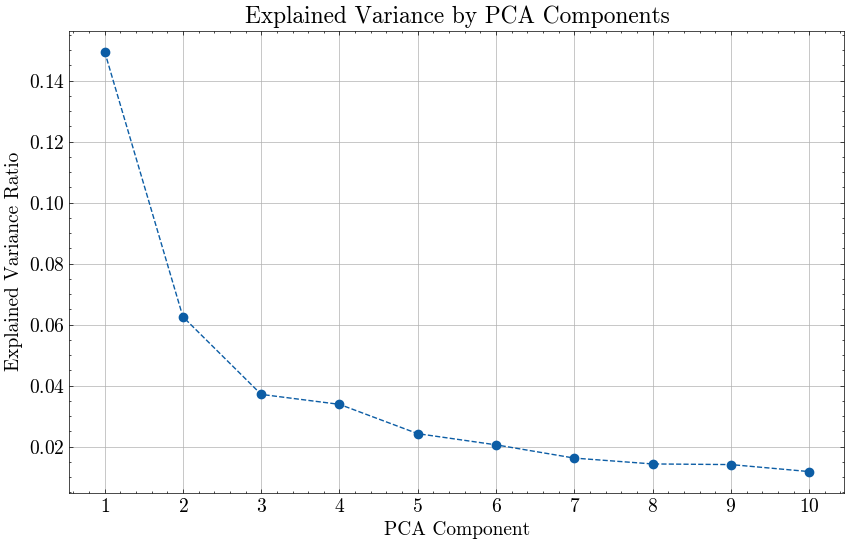

In [76]:
fingerprints_umap2 = pca_umap_reduction(
    [fingerprints], pca_components=10, plot_variance=True)

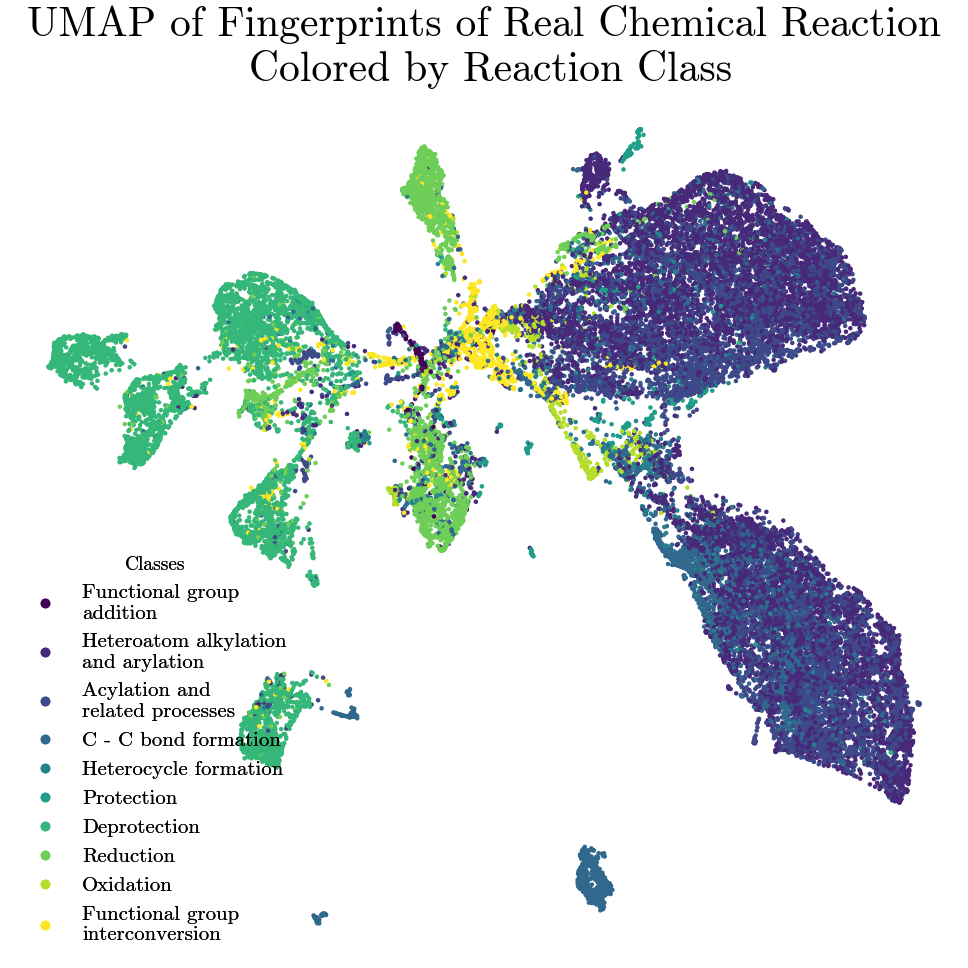

In [100]:
reaction_type_encoded = df_with_max_200["reaction_type"].apply(
    lambda x: rxn2number[x])

# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap2[:, 0], fingerprints_umap2[:, 1], s=5, c=reaction_type_encoded, cmap='viridis')

# Adding the legend with the correct labels
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes", fontsize=15)
for i, text in enumerate(legend1.get_texts()):
    text.set_text(reaction_data[i])
ax.add_artist(legend1)
ax.set_axis_off()

plt.title(
    "UMAP of Fingerprints of Real Chemical Reaction\n Colored by Reaction Class", fontsize=30)

plt.tight_layout()
# plt.show()
plt.savefig("results/new/umap_original_colored_by_rxns.pdf",
            bbox_inches='tight')

In [78]:
import torch
import random
import json
with open("config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()

# fix seeds
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [79]:
from eval import Evaluator
from generate import VAEGenerator
from utils import predict_rxn_type
vae_generator = VAEGenerator(config)
evaluator = Evaluator(config)
# "model_weights/synthesizer/reproduced/v4/vae_epoch76_kl1_warm_up10_aggressiveFalse_loss49.0124.pt"
vae_generator.generate_samples(seed=1000)
evaluator.load_generated_dataset(config["gene_path"])

evaluator.process_results(use_filters=False)
evaluator.rxn_pred = predict_rxn_type(
    evaluator.rxn_classifier, evaluator.gen_fingerprints)
gen_fingerprints_1 = evaluator.gen_fingerprints
rxn_pred_1 = evaluator.rxn_pred

evaluator.process_results(use_filters=True)
evaluator.rxn_pred = predict_rxn_type(
    evaluator.rxn_classifier, evaluator.gen_fingerprints)
gen_fingerprints_2 = evaluator.gen_fingerprints
rxn_pred_2 = evaluator.rxn_pred

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

In [80]:
len(gen_fingerprints_1), len(gen_fingerprints_2)

(32470, 3846)

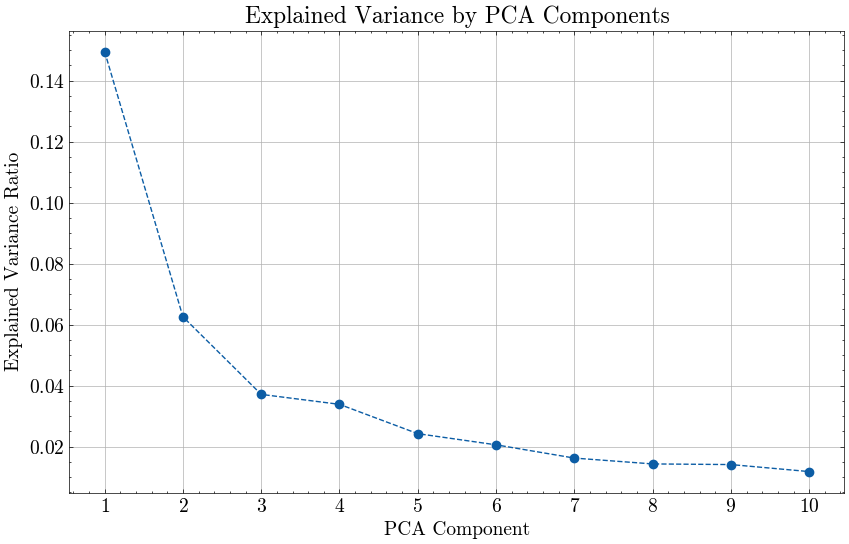

In [81]:
fingerprints_umap2, fingerprints_umap21, fingerprints_umap22 = pca_umap_reduction(
    [fingerprints, gen_fingerprints_1, gen_fingerprints_2], pca_components=10, plot_variance=True)

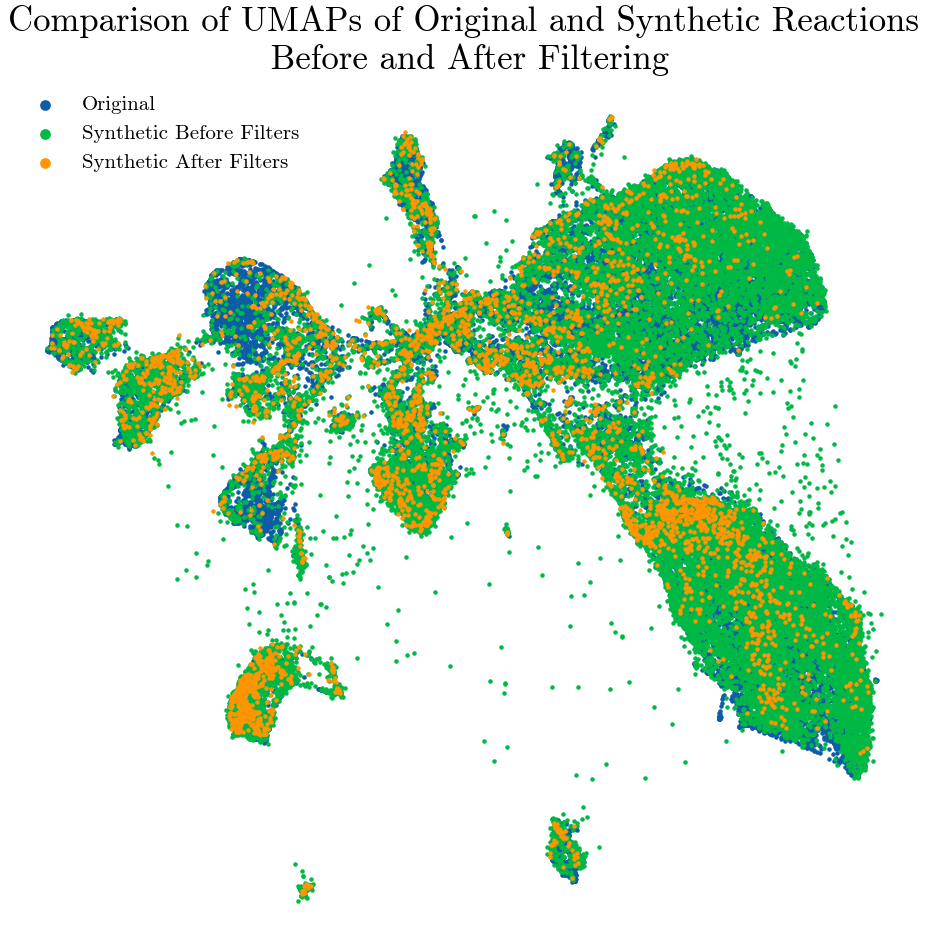

In [101]:
# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap2[:, 0], fingerprints_umap2[:, 1], s=5, label="Original")
scatter = ax.scatter(
    fingerprints_umap21[:, 0], fingerprints_umap21[:, 1], s=5, label="Synthetic Before Filters")
scatter = ax.scatter(
    fingerprints_umap22[:, 0], fingerprints_umap22[:, 1], s=5, label="Synthetic After Filters")


plt.title(
    "Comparison of UMAPs of Original and Synthetic Reactions\n Before and After Filtering", fontsize=25)

plt.tight_layout()
plt.legend(fontsize=15, markerscale=3)
ax.set_axis_off()
# plt.show()
plt.savefig("results/new/rxn_umap_before_after.pdf",
            bbox_inches='tight')

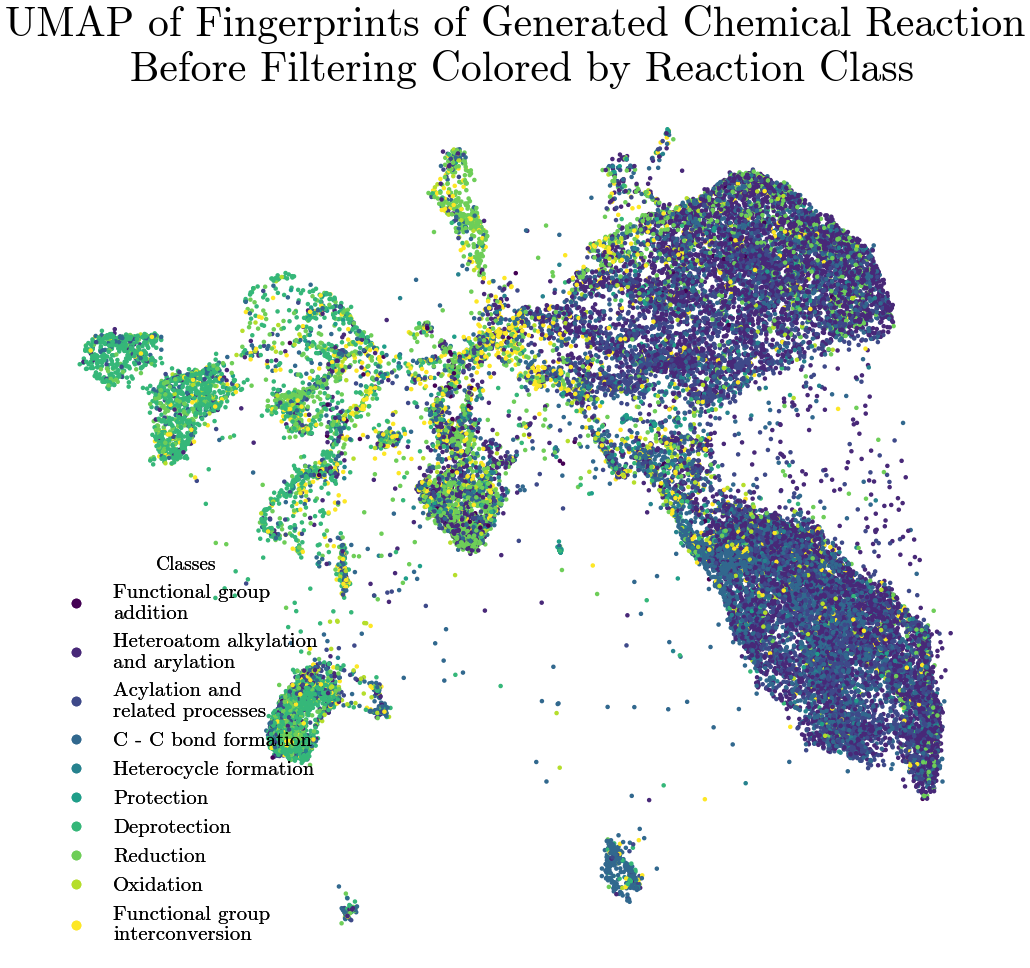

In [102]:
# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap21[:, 0], fingerprints_umap21[:, 1], s=5, c=rxn_pred_1, cmap='viridis')

# Adding the legend with the correct labels
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes", fontsize=15)
for i, text in enumerate(legend1.get_texts()):
    text.set_text(reaction_data[i])
ax.add_artist(legend1)
ax.set_axis_off()

plt.title(
    "UMAP of Fingerprints of Generated Chemical Reaction\n Before Filtering Colored by Reaction Class", fontsize=30)

plt.tight_layout()
plt.savefig("results/new/umap_generated_before_filtering_colored_by_rxns.pdf",
            bbox_inches='tight')

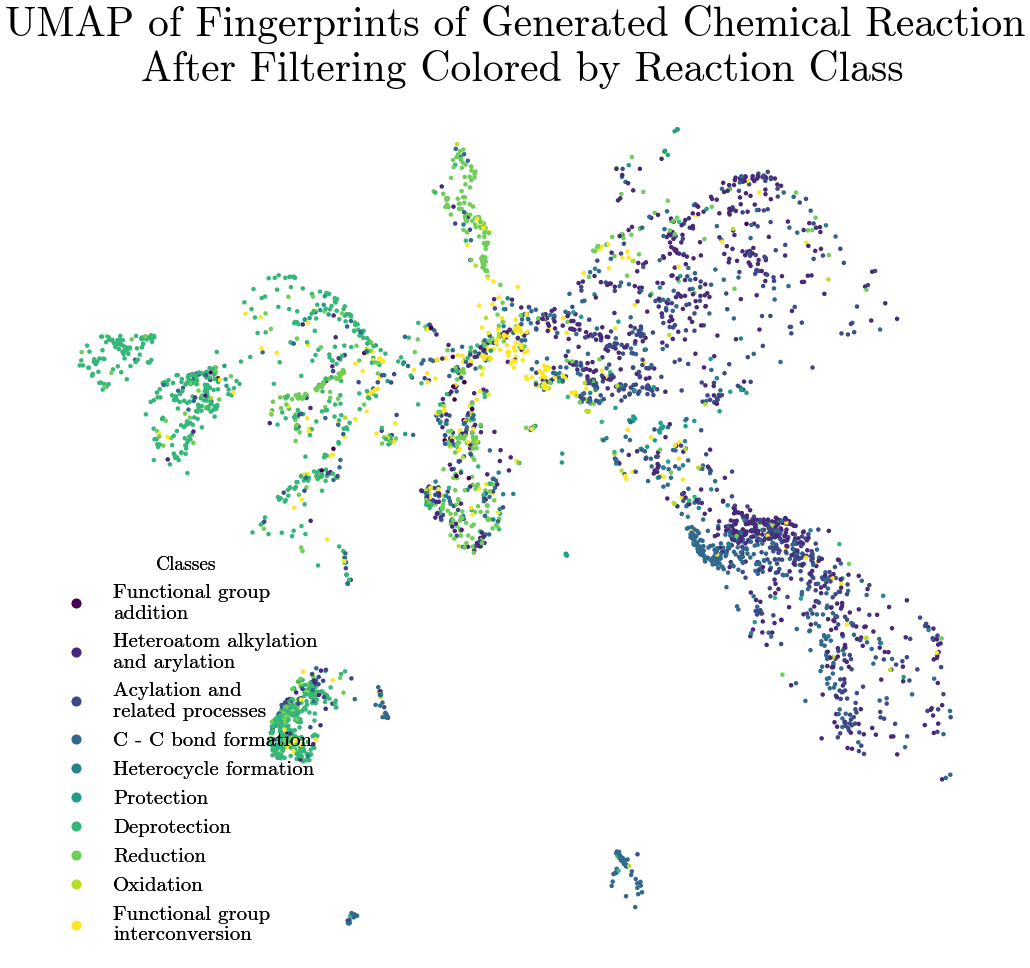

In [104]:
# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap22[:, 0], fingerprints_umap22[:, 1], s=5, c=rxn_pred_2, cmap='viridis')

# Adding the legend with the correct labels
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes", fontsize=15)
for i, text in enumerate(legend1.get_texts()):
    text.set_text(reaction_data[i])
ax.add_artist(legend1)
ax.set_axis_off()

plt.title(
    "UMAP of Fingerprints of Generated Chemical Reaction\n After Filtering Colored by Reaction Class", fontsize=30)

plt.tight_layout()
# plt.show()
plt.savefig("results/new/umap_generated_after_filtering_colored_by_rxns.pdf",
            bbox_inches='tight')

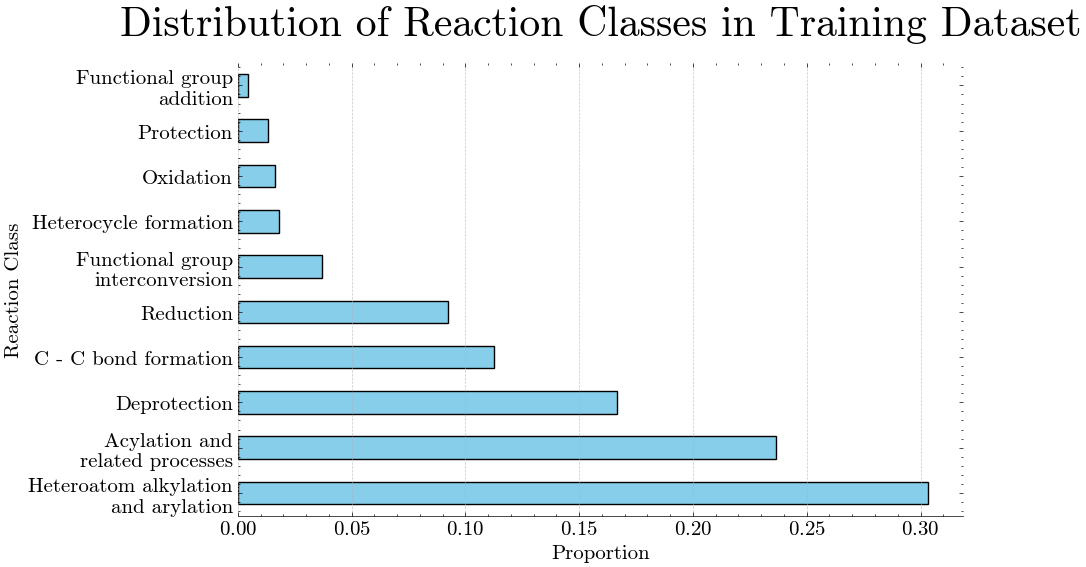

In [108]:
reaction_data = {
    "<RX_1>": "Heteroatom alkylation\nand arylation",
    "<RX_2>": "Acylation and\nrelated processes",
    "<RX_3>": "C - C bond formation",
    "<RX_4>": "Heterocycle formation",
    "<RX_5>": "Protection",
    "<RX_6>": "Deprotection",
    "<RX_7>": "Reduction",
    "<RX_8>": "Oxidation",
    "<RX_9>": "Functional group\ninterconversion",
    "<RX_10>": "Functional group\naddition"
}

# Convert reaction codes to descriptions and calculate the frequency
reaction_counts = df_with_max_200["reaction_type"].apply(
    lambda x: reaction_data[x]).value_counts(normalize=True)

# Plotting
plt.figure(figsize=(10, 6))
reaction_counts.plot(kind='barh', color='skyblue', edgecolor='black')

# Beautify the plot
plt.title('Distribution of Reaction Classes in Training Dataset',
          fontsize=30, weight='bold', pad=20)
plt.xlabel('Proportion', fontsize=15, weight='bold')
plt.ylabel('Reaction Class', fontsize=15, weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Removing the spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
# plt.show()
plt.savefig("results/new/rxn_bar.pdf",
            bbox_inches='tight', dpi=500)

In [89]:
valid_df = evaluator.df[evaluator.df["isValid"]].copy()
valid_df["rxn_type"] = rxn_pred_1
valid_df.shape

(32470, 13)

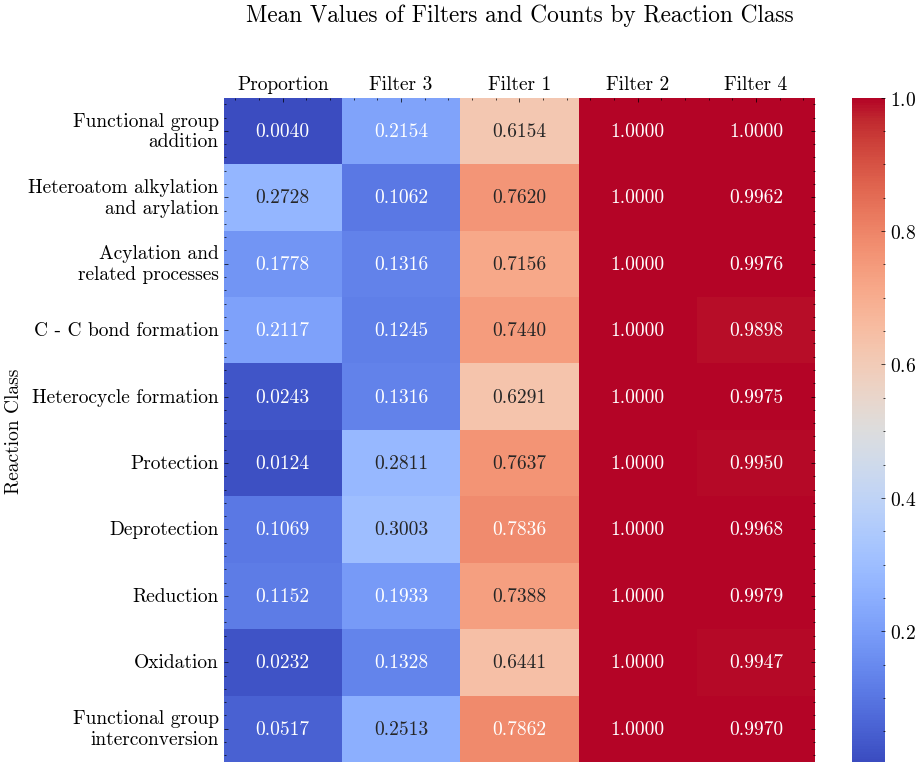

In [90]:
import seaborn as sns
reaction_data = {
    1: "Heteroatom alkylation\nand arylation",
    2: "Acylation and\nrelated processes",
    3: "C - C bond formation",
    4: "Heterocycle formation",
    5: "Protection",
    6: "Deprotection",
    7: "Reduction",
    8: "Oxidation",
    9: "Functional group\ninterconversion",
    0: "Functional group\naddition"
}

heatmap_data = valid_df.groupby("rxn_type")[
    ["Filter_4", "Filter_0", "Filter_2", "Filter_5"]
].mean().join(valid_df["rxn_type"].value_counts(normalize=True).rename("Proportion"))

heatmap_data.index = heatmap_data.index.map(reaction_data)
heatmap_data = heatmap_data.rename(
    {"Filter_4": "Filter 3", "Filter_0": "Filter 1", "Filter_2": "Filter 2", "Filter_5": "Filter 4"}, axis=1)
heatmap_data = heatmap_data[["Proportion",
                             "Filter 3", "Filter 1", "Filter 2", "Filter 4"]]

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',
            fmt=".4f", cbar_kws={'orientation': 'vertical'})

# Move the x-axis ticks to the top
plt.xticks(rotation=45, ha='left')  # Rotate for better readability
plt.gca().xaxis.set_ticks_position('top')  # Move x-axis ticks to the top

# Set the title and labels
plt.title("Mean Values of Filters and Counts by Reaction Class\n", pad=20)
plt.ylabel("Reaction Class")

# Save the plot to a file
plt.tight_layout()
plt.savefig(os.path.join("results/new", "grid_filters_rxntype.pdf"),
            bbox_inches='tight', dpi=500)

# Display the plot
plt.show()

In [113]:
reaction_data = {
    "<RX_1>": "Heteroatom alkylation\nand arylation",
    "<RX_2>": "Acylation and\nrelated processes",
    "<RX_3>": "C - C bond formation",
    "<RX_4>": "Heterocycle formation",
    "<RX_5>": "Protection",
    "<RX_6>": "Deprotection",
    "<RX_7>": "Reduction",
    "<RX_8>": "Oxidation",
    "<RX_9>": "Functional group\ninterconversion",
    "<RX_10>": "Functional group\naddition"
}

# Convert reaction codes to descriptions and calculate the frequency
reaction_counts_og = df_with_max_200["reaction_type"].apply(
    lambda x: reaction_data[x]).value_counts(normalize=True)
reaction_counts_og

reaction_type
Heteroatom alkylation\nand arylation    0.303501
Acylation and\nrelated processes        0.236329
Deprotection                            0.166578
C - C bond formation                    0.112375
Reduction                               0.092201
Functional group\ninterconversion       0.036835
Heterocycle formation                   0.018152
Oxidation                               0.016332
Protection                              0.013121
Functional group\naddition              0.004576
Name: proportion, dtype: float64

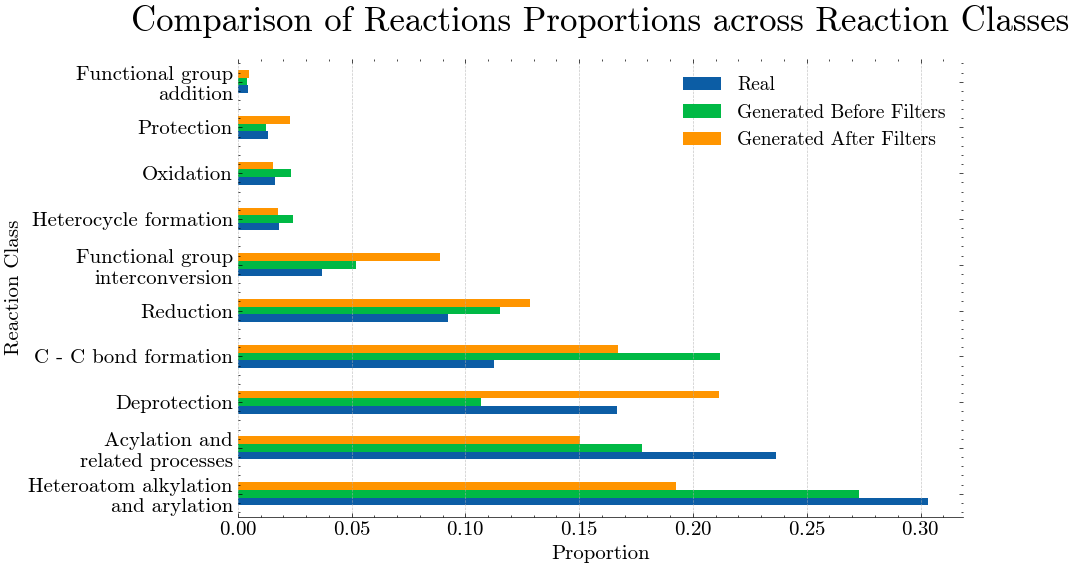

In [132]:
reaction_data = {
    1: "Heteroatom alkylation\nand arylation",
    2: "Acylation and\nrelated processes",
    3: "C - C bond formation",
    4: "Heterocycle formation",
    5: "Protection",
    6: "Deprotection",
    7: "Reduction",
    8: "Oxidation",
    9: "Functional group\ninterconversion",
    0: "Functional group\naddition"
}
reaction_counts_1 = pd.Series(rxn_pred_1).apply(
    lambda x: reaction_data[x]).value_counts(normalize=True)
reaction_counts_2 = pd.Series(rxn_pred_2).apply(
    lambda x: reaction_data[x]).value_counts(normalize=True)
result_df = pd.concat(
    [reaction_counts_og, reaction_counts_1, reaction_counts_2], axis=1)
result_df.columns = [
    "Real", "Generated Before Filters", "Generated After Filters"]
result_df.plot(kind='barh', figsize=(10, 6))
plt.title('Comparison of Reactions Proportions across Reaction Classes',
          fontsize=25, weight='bold', pad=20)
plt.xlabel('Proportion', fontsize=15, weight='bold')
plt.ylabel('Reaction Class', fontsize=15, weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Removing the spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
# plt.show()
plt.savefig("results/new/rxn_bar_across_datasets.pdf",
            bbox_inches='tight', dpi=500)

## Model Performance

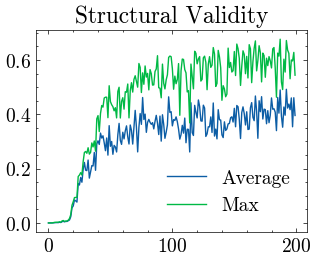

Avg Validity 0.4921 192 Maximum: 0.6717 Std: 0.1444
Max Validity 0.6765 187 Average: 0.4896 Std: 0.1814


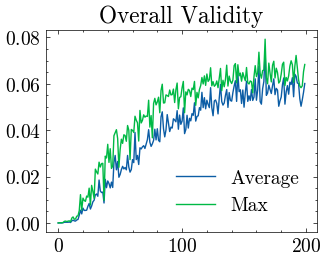

Avg Overall Validity 0.0743 167 Maximum: 0.0792 Std: 0.0029
Max Overall Validity 0.0792 167 Average: 0.0743 Std: 0.0029


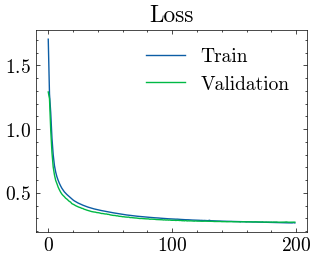

186
0.2694 0.2702


In [39]:
import re
import matplotlib.pyplot as plt
logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v2/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "- Validity                  (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Structural Validity")
plt.legend()
plt.show()
print("Avg Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])
patt = re.compile(
    "- Overall Validity          (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Overall Validity")
plt.legend()
plt.show()
print("Avg Overall Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Overall Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])
patt = re.compile(
    "val loss:  (\d.\d\d\d\d)")
val_losses = patt.findall(logv2_str)
patt = re.compile(
    "Train Loss: (\d.\d\d\d\d\d)")
train_losses = patt.findall(logv2_str)
train_losses = [float(loss) for loss in train_losses]
val_losses = [float(loss) for loss in val_losses]
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.title("Loss")
plt.legend()
plt.show()
print(np.argmin(val_losses))
print(np.min(val_losses), val_losses[-1])

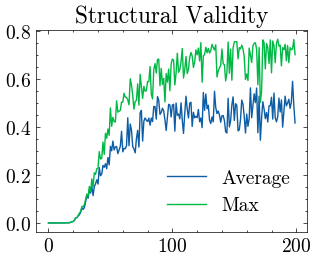

Avg Validity 0.5903 197 Maximum: 0.725 Std: 0.17
Max Validity 0.7659 185 Average: 0.442 Std: 0.235


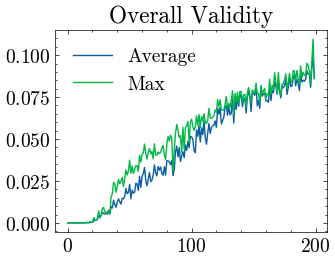

Avg Overall Validity 0.0996 198 Maximum: 0.1095 Std: 0.0065
Max Overall Validity 0.1095 198 Average: 0.0996 Std: 0.0065


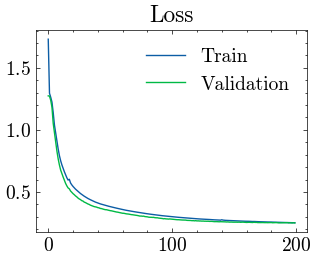

199
0.2505 0.2505


In [36]:
import re
import matplotlib.pyplot as plt
logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v2.2/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "- Validity                  (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Structural Validity")
plt.legend()
plt.show()
print("Avg Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])
patt = re.compile(
    "- Overall Validity          (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Overall Validity")
plt.legend()
plt.show()
print("Avg Overall Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Overall Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])
patt = re.compile(
    "val loss:  (\d.\d\d\d\d)")
val_losses = patt.findall(logv2_str)
patt = re.compile(
    "Train Loss: (\d.\d\d\d\d\d)")
train_losses = patt.findall(logv2_str)
train_losses = [float(loss) for loss in train_losses]
val_losses = [float(loss) for loss in val_losses]
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.title("Loss")
plt.legend()
plt.show()
print(np.argmin(val_losses))
print(np.min(val_losses), val_losses[-1])

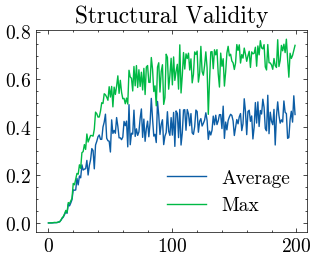

Avg Validity 0.5341 177 Maximum: 0.7462 Std: 0.2495
Max Validity 0.7685 192 Average: 0.4576 Std: 0.1961


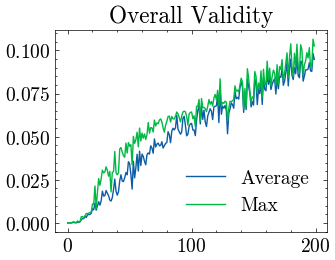

Avg Overall Validity 0.0982 198 Maximum: 0.1065 Std: 0.0054
Max Overall Validity 0.1065 198 Average: 0.0982 Std: 0.0054


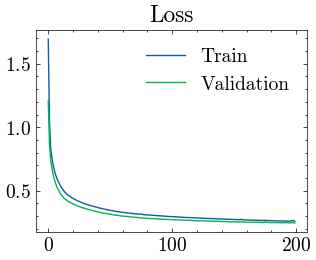

194
0.2445 0.2445


In [35]:
import re
import matplotlib.pyplot as plt
logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v2.3/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "- Validity                  (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Structural Validity")
plt.legend()
plt.show()
print("Avg Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])
patt = re.compile(
    "- Overall Validity          (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Overall Validity")
plt.legend()
plt.show()
print("Avg Overall Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Overall Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])
patt = re.compile(
    "val loss:  (\d.\d\d\d\d)")
val_losses = patt.findall(logv2_str)
patt = re.compile(
    "Train Loss: (\d.\d\d\d\d\d)")
train_losses = patt.findall(logv2_str)
train_losses = [float(loss) for loss in train_losses]
val_losses = [float(loss) for loss in val_losses]
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.title("Loss")
plt.legend()
plt.show()
print(np.argmin(val_losses))
print(np.min(val_losses), val_losses[-1])

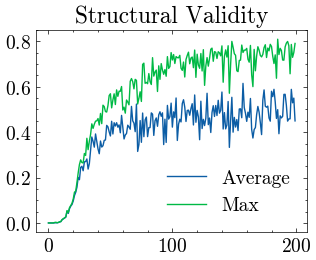

Avg Validity 0.6151 157 Maximum: 0.7514 Std: 0.1534
Max Validity 0.8098 185 Average: 0.4992 Std: 0.2302


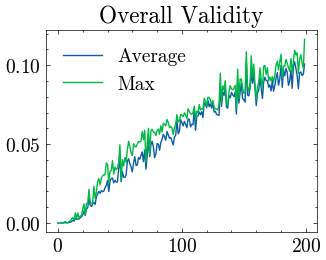

Avg Overall Validity 0.1022 191 Maximum: 0.1095 Std: 0.006
Max Overall Validity 0.1165 199 Average: 0.1007 Std: 0.0127


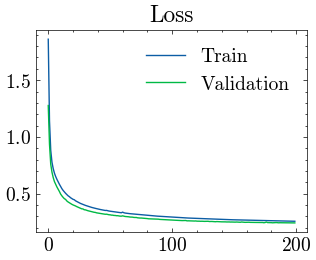

197
0.2428 0.2432


In [34]:
import re
import matplotlib.pyplot as plt
logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v2.4/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "- Validity                  (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Structural Validity")
plt.legend()
plt.show()
print("Avg Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])
patt = re.compile(
    "- Overall Validity          (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Overall Validity")
plt.legend()
plt.show()
print("Avg Overall Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Overall Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])
patt = re.compile(
    "val loss:  (\d.\d\d\d\d)")
val_losses = patt.findall(logv2_str)
patt = re.compile(
    "Train Loss: (\d.\d\d\d\d\d)")
train_losses = patt.findall(logv2_str)
train_losses = [float(loss) for loss in train_losses]
val_losses = [float(loss) for loss in val_losses]
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.title("Loss")
plt.legend()
plt.show()
print(np.argmin(val_losses))
print(np.min(val_losses), val_losses[-1])

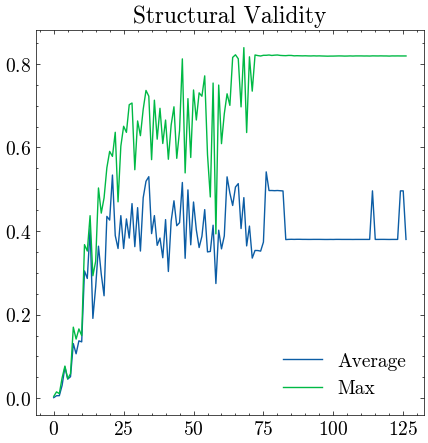

Avg Structural Validity 0.5415 76 Maximum: 0.8204 Std: 0.2494
Max Structural Validity 0.8387 68 Average: 0.4799 Std: 0.2462


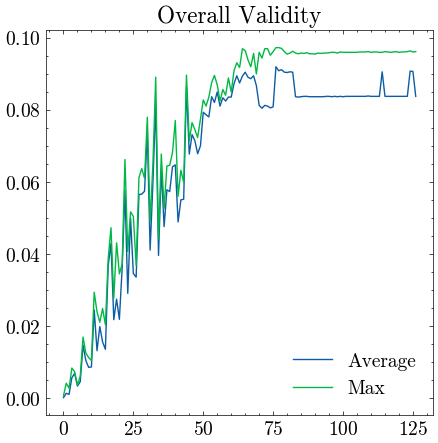

Avg Overall Validity 0.0919 76 Maximum: 0.0972 Std: 0.0032
Max Overall Validity 0.0972 76 Average: 0.0919 Std: 0.0032


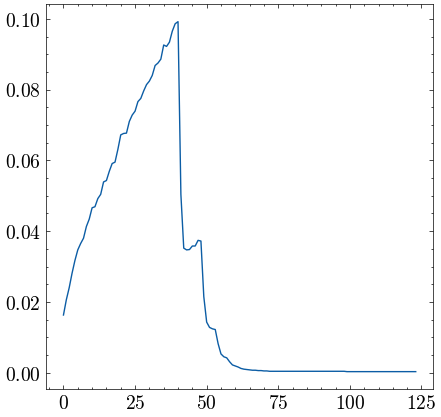

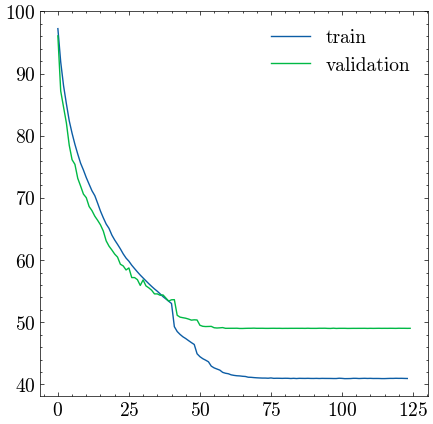

65


In [31]:
import re
import matplotlib.pyplot as plt
logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v4/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "- Validity                  (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Structural Validity")
plt.legend()
plt.show()
print("Avg Structural Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Structural Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])

patt = re.compile(
    "- Overall Validity          (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Overall Validity")
plt.legend()
plt.show()
print("Avg Overall Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Overall Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])

patt = re.compile("epoch: \d+, avg_loss: \d\d.\d\d\d\d, kl: (\d.\d\d\d\d)")
vals = patt.findall(logv2_str)
vals = [float(val) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(vals)
plt.show()

patt = re.compile("epoch: \d+, avg_loss: (\d\d.\d\d\d\d)")
vals = patt.findall(logv2_str)
train_vals = [float(val) for val in vals]
patt = re.compile("VAL --- avg_loss: (\d\d.\d\d\d\d)")
vals = patt.findall(logv2_str)
valid_vals = [float(val) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(train_vals, label="train")
plt.plot(valid_vals, label="validation")
plt.legend()
plt.show()
print(np.argmin(valid_vals))

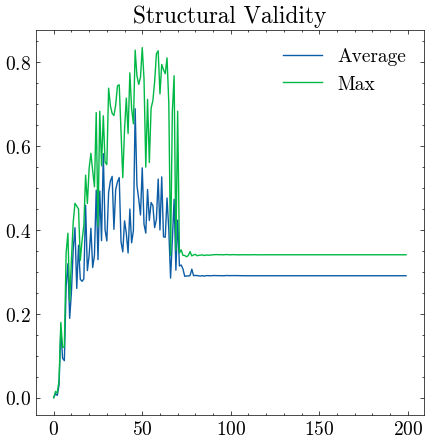

Avg Structural Validity 0.6894 46 Maximum: 0.829 Std: 0.1831
Max Structural Validity 0.835 50 Average: 0.5483 Std: 0.2815


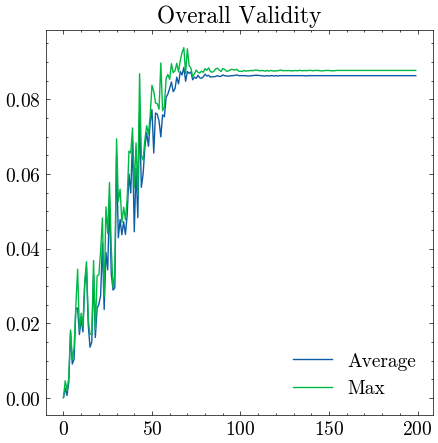

Avg Overall Validity 0.0885 68 Maximum: 0.0938 Std: 0.0042
Max Overall Validity 0.0938 68 Average: 0.0885 Std: 0.0042


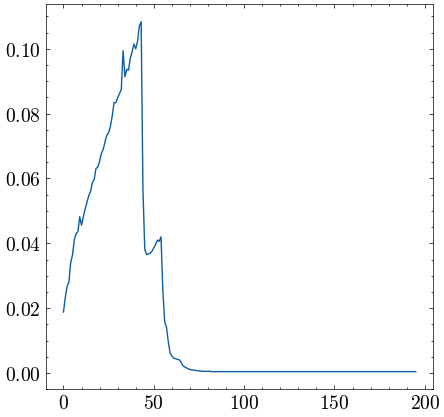

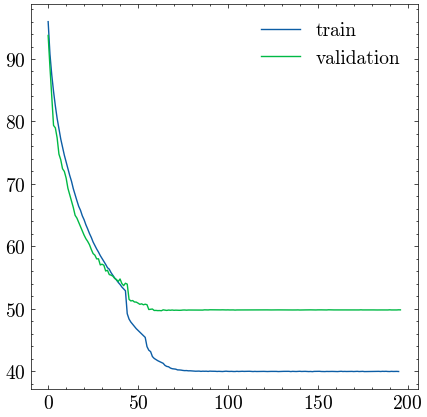

63


In [30]:
logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v4.2/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "- Validity                  (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Structural Validity")
plt.legend()
plt.show()
print("Avg Structural Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Structural Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])

patt = re.compile(
    "- Overall Validity          (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Overall Validity")
plt.legend()
plt.show()
print("Avg Overall Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Overall Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])

patt = re.compile("epoch: \d+, avg_loss: \d\d.\d\d\d\d, kl: (\d.\d\d\d\d)")
vals = patt.findall(logv2_str)
vals = [float(val) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(vals)
plt.show()

patt = re.compile("epoch: \d+, avg_loss: (\d\d.\d\d\d\d)")
vals = patt.findall(logv2_str)
train_vals = [float(val) for val in vals]
patt = re.compile("VAL --- avg_loss: (\d\d.\d\d\d\d)")
vals = patt.findall(logv2_str)
valid_vals = [float(val) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(train_vals, label="train")
plt.plot(valid_vals, label="validation")
plt.legend()
plt.show()
print(np.argmin(valid_vals))

## Model Performance based on Evaluation Metrics

In [1]:
def generate_and_evaluate(generator, evaluator, generated_path):
    # Initialize metrics dictionary
    metrics = {
        "JSS": [],
        "Similarity": [],
        "String Similarity": [],
        "Validity": [],
        "Exact Matches Percentage": [],
        "Duplicates Percentage": [],
        "Average Inter Dissimilarity": [],
        "Overall Validity": [],
        "Normalized Vendi Score": [],
        "Normalized Vendi Score (q=0.1)": [],
        "Normalized Vendi Score (q=inf)": [],
        "Avg Normalized Vendi Score Per Class": [],
        "Filter 1": [],
        "Filter 2": [],
        "Filter 3": [],
        "Filter 4": [],
    }

    seeds = [42, 0, 250, 1000, 350]

    for seed in seeds:
        generator.generate_samples(seed=seed)
        evaluator.generate_metrics_evaluation(generated_path)
        metrics["JSS"].append(evaluator.results["jss"])
        metrics["Similarity"].append(
            evaluator.results["avg_similarity"])
        metrics["String Similarity"].append(
            evaluator.results["avg_str_similarity"])
        metrics["Validity"].append(evaluator.results["valid"])
        metrics["Exact Matches Percentage"].append(
            evaluator.results["exact_perc"])
        metrics["Duplicates Percentage"].append(
            evaluator.results["duplicates_perc"])
        metrics["Average Inter Dissimilarity"].append(
            evaluator.results["average_inter_dissimilarity"])
        metrics["Overall Validity"].append(
            evaluator.results["validated"])
        metrics["Normalized Vendi Score"].append(
            evaluator.results["vendi_score_k"])
        metrics["Normalized Vendi Score (q=0.1)"].append(
            evaluator.results["vendi_score_k_small"])
        metrics["Normalized Vendi Score (q=inf)"].append(
            evaluator.results["vendi_score_k_inf"])
        metrics["Avg Normalized Vendi Score Per Class"].append(
            evaluator.results["avg_vs_score_per_class"])
        metrics["Filter 1"].append(evaluator.results["filter0"])
        metrics["Filter 2"].append(evaluator.results["filter2"])
        metrics["Filter 3"].append(evaluator.results["filter4"])
        metrics["Filter 4"].append(evaluator.results["filter5"])

        # Print the results for the current seed
        print(f"""Seed {seed}: JSS={evaluator.results['jss']:.4f}, Sim={evaluator.results['avg_similarity']:.4f}, StrSim={evaluator.results['avg_str_similarity']:.4f}, Val={evaluator.results['valid']:.4f}, ExactMatchesPerc={evaluator.results['exact_perc']:.4f}, 
            DuplicatesPerc={evaluator.results['duplicates_perc']:.4f}, IntDiv={evaluator.results['average_inter_dissimilarity']:.4f}, OverallVal={evaluator.results['validated']:.4f}, 
            NVS={evaluator.results['vendi_score_k']:.4f}, NVS(q=0.1)={evaluator.results['vendi_score_k_small']:.4f}, NVS(q=inf)={evaluator.results['vendi_score_k_inf']:.4f}, AvgNVSPerClass={evaluator.results['avg_vs_score_per_class']:.4f}""")

    # Print summary statistics
    print("\nSummary Statistics:")
    print(
        f"{'Metric':<25} {'Avg':<8} {'Std':<8} {'Min':<8} {'Max':<8}")

    for metric, values in metrics.items():
        print(
            f"{metric:<25} {np.mean(values):<8.4f} {np.std(values):<8.4f} {np.min(values):<8.4f} {np.max(values):<8.4f}")

### V2.1 (LSTM 1 Layer)

In [32]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_1layer_best_config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8241, Sim=0.1929, StrSim=0.8793, Val=0.4411, ExactMatchesPerc=0.0018, 
            DuplicatesPerc=0.0039, IntDiv=0.9746, OverallVal=0.0716, 
            NVS=0.6212, NVS(q=0.1)=0.9500, NVS(q=inf)=0.0127, AvgNVSPerClass=0.8039
Seed 0: JSS=0.7847, Sim=0.1839, StrSim=0.8855, Val=0.2658, ExactMatchesPerc=0.0013, 
            DuplicatesPerc=0.0061, IntDiv=0.9678, OverallVal=0.0792, 
            NVS=0.5732, NVS(q=0.1)=0.9475, NVS(q=inf)=0.0086, AvgNVSPerClass=0.8148
Seed 250: JSS=0.8169, Sim=0.1961, StrSim=0.8781, Val=0.6702, ExactMatchesPerc=0.0021, 
            DuplicatesPerc=0.0080, IntDiv=0.9742, OverallVal=0.0726, 
            NVS=0.6166, NVS(q=0.1)=0.9489, NVS(q=inf)=0.0124, AvgNVSPerClass=0.8097
Seed 1000: JSS=0.7947, Sim=0.1875, StrSim=0.8822, Val=0.3036, ExactMatchesPerc=0.0003, 
            DuplicatesPerc=0.0033, IntDiv=0.9717, OverallVal=0.0759, 
            NVS=0.5911, NVS(q=0.1)=0.9464, NVS(q=inf)=0.0103, AvgNVSPerClass=0.7845
Seed 350: JSS=0.8217, Sim=0.1974, StrS

In [2]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_1layer_last_config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

/media/gambino/students_workdir/anis/miniconda3/envs/chemgen_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.7835, Sim=0.1896, StrSim=0.8752, Val=0.4507, ExactMatchesPerc=0.0005, 
            DuplicatesPerc=0.0029, IntDiv=0.9745, OverallVal=0.0527, 
            NVS=0.6712, NVS(q=0.1)=0.9528, NVS(q=inf)=0.0171, AvgNVSPerClass=0.8340
Seed 0: JSS=0.7648, Sim=0.1748, StrSim=0.8825, Val=0.1763, ExactMatchesPerc=0.0016, 
            DuplicatesPerc=0.0024, IntDiv=0.9615, OverallVal=0.0634, 
            NVS=0.5943, NVS(q=0.1)=0.9566, NVS(q=inf)=0.0090, AvgNVSPerClass=0.8239
Seed 250: JSS=0.8143, Sim=0.1960, StrSim=0.8745, Val=0.6144, ExactMatchesPerc=0.0029, 
            DuplicatesPerc=0.0020, IntDiv=0.9736, OverallVal=0.0516, 
            NVS=0.6624, NVS(q=0.1)=0.9526, NVS(q=inf)=0.0169, AvgNVSPerClass=0.8265
Seed 1000: JSS=0.7785, Sim=0.1935, StrSim=0.8768, Val=0.3158, ExactMatchesPerc=0.0009, 
            DuplicatesPerc=0.0054, IntDiv=0.9721, OverallVal=0.0560, 
            NVS=0.6308, NVS(q=0.1)=0.9462, NVS(q=inf)=0.0142, AvgNVSPerClass=0.8138
Seed 350: JSS=0.8112, Sim=0.2023, StrS

### V2.2 (LSTM 2 Layers)

In [33]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_2layers_best_config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8505, Sim=0.2068, StrSim=0.8737, Val=0.5375, ExactMatchesPerc=0.0008, 
            DuplicatesPerc=0.0051, IntDiv=0.9754, OverallVal=0.0989, 
            NVS=0.5551, NVS(q=0.1)=0.9337, NVS(q=inf)=0.0095, AvgNVSPerClass=0.7667
Seed 0: JSS=0.8219, Sim=0.2033, StrSim=0.8787, Val=0.3126, ExactMatchesPerc=0.0011, 
            DuplicatesPerc=0.0048, IntDiv=0.9739, OverallVal=0.0956, 
            NVS=0.5461, NVS(q=0.1)=0.9347, NVS(q=inf)=0.0089, AvgNVSPerClass=0.7617
Seed 250: JSS=0.8474, Sim=0.1960, StrSim=0.8693, Val=0.7646, ExactMatchesPerc=0.0014, 
            DuplicatesPerc=0.0019, IntDiv=0.9745, OverallVal=0.1095, 
            NVS=0.5641, NVS(q=0.1)=0.9414, NVS(q=inf)=0.0083, AvgNVSPerClass=0.7598
Seed 1000: JSS=0.8189, Sim=0.1932, StrSim=0.8828, Val=0.2556, ExactMatchesPerc=0.0017, 
            DuplicatesPerc=0.0034, IntDiv=0.9714, OverallVal=0.0906, 
            NVS=0.5521, NVS(q=0.1)=0.9399, NVS(q=inf)=0.0083, AvgNVSPerClass=0.7845
Seed 350: JSS=0.8537, Sim=0.2022, StrS

In [3]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_2layers_last_config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8017, Sim=0.1871, StrSim=0.8817, Val=0.2553, ExactMatchesPerc=0.0018, 
            DuplicatesPerc=0.0030, IntDiv=0.9702, OverallVal=0.0853, 
            NVS=0.5814, NVS(q=0.1)=0.9495, NVS(q=inf)=0.0085, AvgNVSPerClass=0.8176
Seed 0: JSS=0.7972, Sim=0.1928, StrSim=0.8781, Val=0.2950, ExactMatchesPerc=0.0015, 
            DuplicatesPerc=0.0051, IntDiv=0.9727, OverallVal=0.0851, 
            NVS=0.5803, NVS(q=0.1)=0.9415, NVS(q=inf)=0.0094, AvgNVSPerClass=0.7731
Seed 250: JSS=0.8358, Sim=0.1995, StrSim=0.8716, Val=0.7013, ExactMatchesPerc=0.0020, 
            DuplicatesPerc=0.0012, IntDiv=0.9741, OverallVal=0.0869, 
            NVS=0.5895, NVS(q=0.1)=0.9425, NVS(q=inf)=0.0104, AvgNVSPerClass=0.7802
Seed 1000: JSS=0.8204, Sim=0.1944, StrSim=0.8767, Val=0.3402, ExactMatchesPerc=0.0012, 
            DuplicatesPerc=0.0000, IntDiv=0.9745, OverallVal=0.0863, 
            NVS=0.5921, NVS(q=0.1)=0.9459, NVS(q=inf)=0.0103, AvgNVSPerClass=0.8032
Seed 350: JSS=0.8367, Sim=0.1952, StrS

### V2.3 (LSTM 3 Layers)

In [19]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_3layers_best_config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8375, Sim=0.2088, StrSim=0.8731, Val=0.6204, ExactMatchesPerc=0.0025, 
            DuplicatesPerc=0.0081, IntDiv=0.9758, OverallVal=0.1007, 
            NVS=0.5438, NVS(q=0.1)=0.9284, NVS(q=inf)=0.0074, AvgNVSPerClass=0.7688
Seed 0: JSS=0.8088, Sim=0.1956, StrSim=0.8834, Val=0.2392, ExactMatchesPerc=0.0023, 
            DuplicatesPerc=0.0039, IntDiv=0.9714, OverallVal=0.0901, 
            NVS=0.5473, NVS(q=0.1)=0.9374, NVS(q=inf)=0.0083, AvgNVSPerClass=0.7646
Seed 250: JSS=0.8496, Sim=0.2083, StrSim=0.8731, Val=0.5535, ExactMatchesPerc=0.0010, 
            DuplicatesPerc=0.0036, IntDiv=0.9756, OverallVal=0.0978, 
            NVS=0.5493, NVS(q=0.1)=0.9318, NVS(q=inf)=0.0083, AvgNVSPerClass=0.7550
Seed 1000: JSS=0.8432, Sim=0.2049, StrSim=0.8743, Val=0.5237, ExactMatchesPerc=0.0024, 
            DuplicatesPerc=0.0021, IntDiv=0.9758, OverallVal=0.0959, 
            NVS=0.5606, NVS(q=0.1)=0.9361, NVS(q=inf)=0.0085, AvgNVSPerClass=0.7683
Seed 350: JSS=0.8529, Sim=0.2027, StrS

In [4]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_3layers_last_config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8260, Sim=0.2129, StrSim=0.8748, Val=0.6096, ExactMatchesPerc=0.0027, 
            DuplicatesPerc=0.0069, IntDiv=0.9758, OverallVal=0.0956, 
            NVS=0.5507, NVS(q=0.1)=0.9319, NVS(q=inf)=0.0079, AvgNVSPerClass=0.7747
Seed 0: JSS=0.7793, Sim=0.1980, StrSim=0.8825, Val=0.2040, ExactMatchesPerc=0.0015, 
            DuplicatesPerc=0.0058, IntDiv=0.9692, OverallVal=0.0833, 
            NVS=0.5326, NVS(q=0.1)=0.9339, NVS(q=inf)=0.0083, AvgNVSPerClass=0.7822
Seed 250: JSS=0.8208, Sim=0.2115, StrSim=0.8762, Val=0.3973, ExactMatchesPerc=0.0020, 
            DuplicatesPerc=0.0046, IntDiv=0.9770, OverallVal=0.0882, 
            NVS=0.5589, NVS(q=0.1)=0.9303, NVS(q=inf)=0.0087, AvgNVSPerClass=0.7632
Seed 1000: JSS=0.8195, Sim=0.2110, StrSim=0.8774, Val=0.3543, ExactMatchesPerc=0.0019, 
            DuplicatesPerc=0.0036, IntDiv=0.9759, OverallVal=0.0916, 
            NVS=0.5465, NVS(q=0.1)=0.9312, NVS(q=inf)=0.0080, AvgNVSPerClass=0.7651
Seed 350: JSS=0.7973, Sim=0.2003, StrS

### V2.4 (LSTM 4 Layers)

In [10]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_4layers_best_config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8355, Sim=0.1978, StrSim=0.8718, Val=0.7759, ExactMatchesPerc=0.0012, 
            DuplicatesPerc=0.0044, IntDiv=0.9754, OverallVal=0.1092, 
            NVS=0.5714, NVS(q=0.1)=0.9430, NVS(q=inf)=0.0086, AvgNVSPerClass=0.7747
Seed 0: JSS=0.8149, Sim=0.2025, StrSim=0.8780, Val=0.3644, ExactMatchesPerc=0.0027, 
            DuplicatesPerc=0.0043, IntDiv=0.9754, OverallVal=0.0953, 
            NVS=0.5646, NVS(q=0.1)=0.9389, NVS(q=inf)=0.0096, AvgNVSPerClass=0.7560
Seed 250: JSS=0.8419, Sim=0.1981, StrSim=0.8721, Val=0.7760, ExactMatchesPerc=0.0019, 
            DuplicatesPerc=0.0037, IntDiv=0.9756, OverallVal=0.1095, 
            NVS=0.5676, NVS(q=0.1)=0.9418, NVS(q=inf)=0.0087, AvgNVSPerClass=0.7701
Seed 1000: JSS=0.8312, Sim=0.2045, StrSim=0.8751, Val=0.5481, ExactMatchesPerc=0.0023, 
            DuplicatesPerc=0.0033, IntDiv=0.9756, OverallVal=0.1000, 
            NVS=0.5720, NVS(q=0.1)=0.9427, NVS(q=inf)=0.0094, AvgNVSPerClass=0.7677
Seed 350: JSS=0.8258, Sim=0.2009, StrS

In [5]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_4layers_last_config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8449, Sim=0.1933, StrSim=0.8725, Val=0.7299, ExactMatchesPerc=0.0020, 
            DuplicatesPerc=0.0048, IntDiv=0.9748, OverallVal=0.1013, 
            NVS=0.5963, NVS(q=0.1)=0.9503, NVS(q=inf)=0.0090, AvgNVSPerClass=0.7814
Seed 0: JSS=0.8586, Sim=0.1967, StrSim=0.8728, Val=0.6314, ExactMatchesPerc=0.0016, 
            DuplicatesPerc=0.0037, IntDiv=0.9751, OverallVal=0.0951, 
            NVS=0.6024, NVS(q=0.1)=0.9509, NVS(q=inf)=0.0098, AvgNVSPerClass=0.7813
Seed 250: JSS=0.8460, Sim=0.1978, StrSim=0.8752, Val=0.4783, ExactMatchesPerc=0.0017, 
            DuplicatesPerc=0.0025, IntDiv=0.9752, OverallVal=0.0916, 
            NVS=0.5998, NVS(q=0.1)=0.9506, NVS(q=inf)=0.0102, AvgNVSPerClass=0.7851
Seed 1000: JSS=0.8065, Sim=0.1858, StrSim=0.8813, Val=0.2160, ExactMatchesPerc=0.0012, 
            DuplicatesPerc=0.0036, IntDiv=0.9690, OverallVal=0.0839, 
            NVS=0.5742, NVS(q=0.1)=0.9506, NVS(q=inf)=0.0081, AvgNVSPerClass=0.7975
Seed 350: JSS=0.8506, Sim=0.1992, StrS

### V4 (VAE)

In [13]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/VAE_vanilla_best_config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with VAE


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.7910, Sim=0.1909, StrSim=0.8823, Val=0.2343, ExactMatchesPerc=0.0037, 
            DuplicatesPerc=0.0066, IntDiv=0.9690, OverallVal=0.0876, 
            NVS=0.5814, NVS(q=0.1)=0.9547, NVS(q=inf)=0.0078, AvgNVSPerClass=0.8071
Seed 0: JSS=0.8047, Sim=0.1942, StrSim=0.8849, Val=0.2471, ExactMatchesPerc=0.0034, 
            DuplicatesPerc=0.0065, IntDiv=0.9698, OverallVal=0.0897, 
            NVS=0.5773, NVS(q=0.1)=0.9536, NVS(q=inf)=0.0080, AvgNVSPerClass=0.7791
Seed 250: JSS=0.8441, Sim=0.2020, StrSim=0.8725, Val=0.7011, ExactMatchesPerc=0.0046, 
            DuplicatesPerc=0.0016, IntDiv=0.9745, OverallVal=0.0930, 
            NVS=0.6197, NVS(q=0.1)=0.9609, NVS(q=inf)=0.0097, AvgNVSPerClass=0.8043
Seed 1000: JSS=0.8484, Sim=0.2041, StrSim=0.8706, Val=0.8204, ExactMatchesPerc=0.0049, 
            DuplicatesPerc=0.0047, IntDiv=0.9747, OverallVal=0.0972, 
            NVS=0.6043, NVS(q=0.1)=0.9537, NVS(q=inf)=0.0094, AvgNVSPerClass=0.7859
Seed 350: JSS=0.8548, Sim=0.2039, StrS

In [2]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/VAE_vanilla_last_config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

/media/gambino/students_workdir/anis/miniconda3/envs/chemgen_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


generating with VAE


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.7940, Sim=0.1929, StrSim=0.8820, Val=0.2311, ExactMatchesPerc=0.0038, 
            DuplicatesPerc=0.0073, IntDiv=0.9682, OverallVal=0.0871, 
            NVS=0.5700, NVS(q=0.1)=0.9509, NVS(q=inf)=0.0077, AvgNVSPerClass=0.7911
Seed 0: JSS=0.8056, Sim=0.1940, StrSim=0.8849, Val=0.2439, ExactMatchesPerc=0.0037, 
            DuplicatesPerc=0.0031, IntDiv=0.9696, OverallVal=0.0883, 
            NVS=0.5744, NVS(q=0.1)=0.9525, NVS(q=inf)=0.0080, AvgNVSPerClass=0.7841
Seed 250: JSS=0.8478, Sim=0.2032, StrSim=0.8732, Val=0.6506, ExactMatchesPerc=0.0053, 
            DuplicatesPerc=0.0022, IntDiv=0.9741, OverallVal=0.0912, 
            NVS=0.6150, NVS(q=0.1)=0.9605, NVS(q=inf)=0.0097, AvgNVSPerClass=0.8003
Seed 1000: JSS=0.8338, Sim=0.2037, StrSim=0.8710, Val=0.8216, ExactMatchesPerc=0.0050, 
            DuplicatesPerc=0.0031, IntDiv=0.9747, OverallVal=0.0964, 
            NVS=0.6026, NVS(q=0.1)=0.9544, NVS(q=inf)=0.0095, AvgNVSPerClass=0.7883
Seed 350: JSS=0.8365, Sim=0.2063, StrS

### V4.2 (VAE + aggressive training)

In [11]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/VAE_aggressive_best_config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

/media/gambino/students_workdir/anis/miniconda3/envs/chemgen_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


generating with VAE


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.7949, Sim=0.1913, StrSim=0.8818, Val=0.2358, ExactMatchesPerc=0.0055, 
            DuplicatesPerc=0.0043, IntDiv=0.9690, OverallVal=0.0829, 
            NVS=0.5833, NVS(q=0.1)=0.9530, NVS(q=inf)=0.0084, AvgNVSPerClass=0.7923
Seed 0: JSS=0.8176, Sim=0.1960, StrSim=0.8778, Val=0.3383, ExactMatchesPerc=0.0049, 
            DuplicatesPerc=0.0052, IntDiv=0.9743, OverallVal=0.0870, 
            NVS=0.6101, NVS(q=0.1)=0.9531, NVS(q=inf)=0.0100, AvgNVSPerClass=0.7684
Seed 250: JSS=0.8458, Sim=0.2033, StrSim=0.8725, Val=0.7199, ExactMatchesPerc=0.0044, 
            DuplicatesPerc=0.0027, IntDiv=0.9749, OverallVal=0.0929, 
            NVS=0.6090, NVS(q=0.1)=0.9523, NVS(q=inf)=0.0099, AvgNVSPerClass=0.7834
Seed 1000: JSS=0.8476, Sim=0.2007, StrSim=0.8717, Val=0.7680, ExactMatchesPerc=0.0048, 
            DuplicatesPerc=0.0038, IntDiv=0.9748, OverallVal=0.0938, 
            NVS=0.6116, NVS(q=0.1)=0.9545, NVS(q=inf)=0.0098, AvgNVSPerClass=0.7838
Seed 350: JSS=0.8151, Sim=0.2020, StrS

In [3]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/VAE_aggressive_last_config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with VAE


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.7948, Sim=0.1872, StrSim=0.8821, Val=0.2284, ExactMatchesPerc=0.0062, 
            DuplicatesPerc=0.0047, IntDiv=0.9687, OverallVal=0.0809, 
            NVS=0.5941, NVS(q=0.1)=0.9550, NVS(q=inf)=0.0085, AvgNVSPerClass=0.8017
Seed 0: JSS=0.8070, Sim=0.1910, StrSim=0.8778, Val=0.2926, ExactMatchesPerc=0.0051, 
            DuplicatesPerc=0.0051, IntDiv=0.9719, OverallVal=0.0846, 
            NVS=0.6075, NVS(q=0.1)=0.9540, NVS(q=inf)=0.0092, AvgNVSPerClass=0.7807
Seed 250: JSS=0.8126, Sim=0.1878, StrSim=0.8773, Val=0.3280, ExactMatchesPerc=0.0035, 
            DuplicatesPerc=0.0032, IntDiv=0.9734, OverallVal=0.0791, 
            NVS=0.6419, NVS(q=0.1)=0.9623, NVS(q=inf)=0.0105, AvgNVSPerClass=0.8081
Seed 1000: JSS=0.8529, Sim=0.1965, StrSim=0.8715, Val=0.7727, ExactMatchesPerc=0.0038, 
            DuplicatesPerc=0.0035, IntDiv=0.9745, OverallVal=0.0876, 
            NVS=0.6311, NVS(q=0.1)=0.9574, NVS(q=inf)=0.0103, AvgNVSPerClass=0.8071
Seed 350: JSS=0.8084, Sim=0.1938, StrS

## Miscellaneous

In [8]:
from pdf2image import convert_from_path
images = convert_from_path('results/new/rxn_umap_before_after.pdf', dpi=300)
images[0].save('results/new/rxn_umap_before_after.jpg', 'JPEG')

images = convert_from_path(
    'results/new/umap_generated_after_filtering_colored_by_rxns.pdf', dpi=300)
images[0].save(
    'results/new/umap_generated_after_filtering_colored_by_rxns.jpg', 'JPEG')

images = convert_from_path(
    'results/new/umap_generated_before_filtering_colored_by_rxns.pdf', dpi=300)
images[0].save(
    'results/new/umap_generated_before_filtering_colored_by_rxns.jpg', 'JPEG')

images = convert_from_path(
    'results/new/umap_original_colored_by_rxns.pdf', dpi=300)
images[0].save('results/new/umap_original_colored_by_rxns.jpg', 'JPEG')

In [18]:
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multicomp as mc

# Given lists of means and standard deviations
means = [0.4674, 0.4903, 0.5318, 0.5669, 0.5415, 0.4736]
stds = [0.17, 0.19, 0.16, 0.18, 0.25, 0.22]
sample_size = 100  # Assuming a fixed sample size for each group

# Generate synthetic data based on means and standard deviations
data = [np.random.normal(mean, std, sample_size)
        for mean, std in zip(means, stds)]

# Perform One-Way ANOVA
f_statistic, p_value = stats.f_oneway(*data)
print(f"ANOVA F-statistic: {f_statistic}, p-value: {p_value}")

# If p-value < 0.05, we reject the null hypothesis (at least one group mean is different)
if p_value < 0.05:
    print("There is a significant difference between the group means.")
else:
    print("No significant difference between the group means.")

# Conduct Tukey's HSD Post-hoc Test
# Flatten the data and create corresponding group labels
flat_data = np.concatenate(data)
groups = np.array(['Group 1']*sample_size + ['Group 2'] *
                  sample_size + ['Group 3']*sample_size + ['Group 4']*sample_size + ['Group 5']*sample_size + ['Group 6']*sample_size)

# Perform Tukey's HSD test
tukey_result = mc.pairwise_tukeyhsd(flat_data, groups)
print(tukey_result)

# To rank the groups based on their means
group_ranking = sorted(zip(means, range(1, len(means) + 1)), reverse=True)
print("Group Ranking based on means:", group_ranking)

ANOVA F-statistic: 7.925346319408482, p-value: 3.0537260416994934e-07
There is a significant difference between the group means.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Group 1 Group 2   0.0448  0.573 -0.0333  0.1229  False
Group 1 Group 3   0.0924 0.0099  0.0143  0.1706   True
Group 1 Group 4   0.1364    0.0  0.0582  0.2145   True
Group 1 Group 5   0.0778  0.052 -0.0004  0.1559  False
Group 1 Group 6  -0.0015    1.0 -0.0797  0.0766  False
Group 2 Group 3   0.0476 0.5036 -0.0305  0.1258  False
Group 2 Group 4   0.0916  0.011  0.0135  0.1697   True
Group 2 Group 5    0.033  0.834 -0.0452  0.1111  False
Group 2 Group 6  -0.0463 0.5361 -0.1244  0.0318  False
Group 3 Group 4   0.0439 0.5936 -0.0342  0.1221  False
Group 3 Group 5  -0.0147 0.9946 -0.0928  0.0635  False
Group 3 Group 6   -0.094 0.0082 -0.1721 -0.0158   True
Group 4 Group 5  -0.0586 0.2655 -0.1368  0.019

In [12]:
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multicomp as mc

# Given lists of means and standard deviations
means = [0.0743, 0.0996, 0.0982, 0.1022, 0.0919, 0.0885]
stds = [0.003, 0.007, 0.005, 0.006, 0.003, 0.004]
sample_size = 100  # Assuming a fixed sample size for each group

# Generate synthetic data based on means and standard deviations
data = [np.random.normal(mean, std, sample_size)
        for mean, std in zip(means, stds)]

# Perform One-Way ANOVA
f_statistic, p_value = stats.f_oneway(*data)
print(f"ANOVA F-statistic: {f_statistic}, p-value: {p_value}")

# If p-value < 0.05, we reject the null hypothesis (at least one group mean is different)
if p_value < 0.05:
    print("There is a significant difference between the group means.")
else:
    print("No significant difference between the group means.")

# Conduct Tukey's HSD Post-hoc Test
# Flatten the data and create corresponding group labels
flat_data = np.concatenate(data)
groups = np.array(['Group 1']*sample_size + ['Group 2'] *
                  sample_size + ['Group 3']*sample_size + ['Group 4']*sample_size + ['Group 5']*sample_size + ['Group 6']*sample_size)

# Perform Tukey's HSD test
tukey_result = mc.pairwise_tukeyhsd(flat_data, groups)
print(tukey_result)

# To rank the groups based on their means
group_ranking = sorted(zip(means, range(1, len(means) + 1)), reverse=True)
print("Group Ranking based on means:", group_ranking)

ANOVA F-statistic: 489.1490531768646, p-value: 7.228604512271747e-208
There is a significant difference between the group means.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Group 1 Group 2   0.0257    0.0  0.0238  0.0276   True
Group 1 Group 3   0.0242    0.0  0.0223  0.0261   True
Group 1 Group 4   0.0286    0.0  0.0267  0.0305   True
Group 1 Group 5   0.0179    0.0   0.016  0.0199   True
Group 1 Group 6    0.014    0.0   0.012  0.0159   True
Group 2 Group 3  -0.0015 0.2447 -0.0034  0.0004  False
Group 2 Group 4   0.0029 0.0002   0.001  0.0048   True
Group 2 Group 5  -0.0077    0.0 -0.0097 -0.0058   True
Group 2 Group 6  -0.0117    0.0 -0.0136 -0.0098   True
Group 3 Group 4   0.0044    0.0  0.0025  0.0063   True
Group 3 Group 5  -0.0063    0.0 -0.0082 -0.0044   True
Group 3 Group 6  -0.0102    0.0 -0.0122 -0.0083   True
Group 4 Group 5  -0.0107    0.0 -0.0126 -0.008

In [1]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
with open("configs/VAE_aggressive_best_config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
evaluator = Evaluator(config)
evaluator.generate_metrics_evaluation(
    "Liu_Kheyer_Retrosynthesis_Data/train/train_targets_ids_200.txt")
print(f""" JSS={evaluator.results['jss']:.4f}, Sim={evaluator.results['avg_similarity']:.4f}, StrSim={evaluator.results['avg_str_similarity']:.4f}, Val={evaluator.results['valid']:.4f}, ExactMatchesPerc={evaluator.results['exact_perc']:.4f}, 
    DuplicatesPerc={evaluator.results['duplicates_perc']:.4f}, IntDiv={evaluator.results['average_inter_dissimilarity']:.4f}, OverallVal={evaluator.results['validated']:.4f}, 
    NVS={evaluator.results['vendi_score_k']:.4f}, NVS(q=0.1)={evaluator.results['vendi_score_k_small']:.4f}, NVS(q=inf)={evaluator.results['vendi_score_k_inf']:.4f}, AvgNVSPerClass={evaluator.results['avg_vs_score_per_class']:.4f}
    Filter 1={evaluator.results["filter0"]:.4f},Filter 2={evaluator.results["filter2"]:.4f},Filter 3={evaluator.results["filter4"]:.4f},Filter 4={evaluator.results["filter5"]:.4f}""")

/media/gambino/students_workdir/anis/miniconda3/envs/chemgen_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_sc

 JSS=0.9404, Sim=0.3116, StrSim=0.8670, Val=0.9360, ExactMatchesPerc=0.9985, 
    DuplicatesPerc=0.0027, IntDiv=0.9790, OverallVal=0.8680, 
    NVS=0.2804, NVS(q=0.1)=0.9263, NVS(q=inf)=0.0012, AvgNVSPerClass=0.4481
    Filter 1=0.9051,Filter 2=0.9360,Filter 3=0.8933,Filter 4=0.9330


In [52]:
import re
import pandas as pd
import numpy as np
import logging

from vendi_score import vendi
from rdkit.Chem import rdChemReactions
from rdkit import Chem
from rdkit import RDLogger

from scipy.spatial.distance import cdist, jensenshannon, pdist, squareform
from utils import get_atoms, rxn_to_chain_ids, rxn_to_ring_ids, get_PO_bonds

lg = RDLogger.logger()
lg.setLevel(RDLogger.DEBUG)


def filter_0(rxn):
    # Split the reaction string into individual molecules
    mols = re.split(r"[>>|.]", rxn)

    # Separate reactants and products
    reactants = [mol for mol in mols[:-1] if mol]
    products = [mols[-1]]

    # Initialize lists to store atom types from reactants and products
    reactant_atoms = []
    product_atoms = []
    # Process reactants
    for mol in reactants:
        if mol:
            # Convert the molecule to a canonical SMILES string without isomeric information
            smiles = Chem.MolToSmiles(
                Chem.MolFromSmiles(mol), isomericSmiles=False)
            mol = Chem.MolFromSmiles(smiles)

            # Extract atoms from the molecule
            atoms = get_atoms(mol)
            reactant_atoms.extend(atoms)

    # Process products
    for mol in products:
        if mol:
            # Convert the molecule to a canonical SMILES string without isomeric information
            smiles = Chem.MolToSmiles(
                Chem.MolFromSmiles(mol), isomericSmiles=False)
            mol = Chem.MolFromSmiles(smiles)

            # Extract atoms from the molecule
            atoms = get_atoms(mol)
            product_atoms.extend(atoms)

    # Check if all product atoms are present in the reactant atoms
    print(set(product_atoms), set(reactant_atoms))
    return set(product_atoms).issubset(set(reactant_atoms))




In [47]:
import sentencepiece as spm
spt_1 = spm.SentencePieceTrainer.train(
    "--input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1")
sp = spm.SentencePieceProcessor()
sp.load('m.model')
print(sp.get_piece_size())
vocabs = [sp.id_to_piece(id) for id in range(sp.get_piece_size())]
print(vocabs)
arr = np.loadtxt(
    "Liu_Kheyer_Retrosynthesis_Data/train/train_targets_ids_200.txt")
df = pd.DataFrame()
df["input_ids"] = [arr[i, :] for i in range(len(arr))]
df["decoded_smiles"] = df["input_ids"].apply(
    lambda x: sp.decode_ids(x.astype(int).tolist()))
df["decoded_smiles"] = df["decoded_smiles"].str.replace("[PAD]", "").str.replace(
    "[EOS]", "").str.replace("[BOS]", "").str.replace(" ", "").str.replace("⁇", "")
evaluator.df["decoded_smiles"] = df["decoded_smiles"]

56
['<unk>', '[BOS]', '[EOS]', '[PAD]', '.', '▁', '#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '>', '@', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'Z', '[', '\\', ']', 'a', 'b', 'c', 'd', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's', 't', 'u']


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

In [55]:
evaluator.df["isValid"] = evaluator.df["decoded_smiles"].apply(is_valid_rxn)
evaluator.df["decoded_smiles"].apply(is_valid_rxn).sum()/evaluator.df.shape[0]

1.0

In [58]:
evaluator.df["Filter_0"] = evaluator.df.apply(lambda x: filter_0(
    x["decoded_smiles"]) if x["isValid"] else False, axis=1)
evaluator.df.apply(lambda x: filter_0(
    x["decoded_smiles"]) if x["isValid"] else False, axis=1).sum()/evaluator.df.shape[0]

{'F', 'O', 'CL', 'C', 'N'} {'F', 'O', 'CL', 'C', 'N', 'S'}
{'O', '[NH]', 'C', 'N', 'S'} {'O', '[NH]', 'C', 'N', 'S'}
{'F', 'B', 'O', 'C', 'N'} {'F', 'B', 'BR', 'O', 'C', 'N'}
{'C', 'O', 'N'} {'C', 'O', 'N'}
{'C', 'N', 'F'} {'C', 'CL', 'N', 'F'}
{'B', '[O-]', 'O', 'C', '[N+]', 'N', 'S'} {'B', '[O-]', 'O', 'CL', 'C', '[N+]', 'N', 'S'}
{'F', 'BR', 'O', 'CL', 'C', 'N', 'S'} {'F', 'BR', 'O', 'CL', 'C', 'N', 'S'}
{'F', 'O', 'CL', 'C', 'N'} {'F', 'O', 'CL', 'C', 'N'}
{'C', 'N'} {'C', 'CL', '[NH]'}
{'C', 'O', 'N', 'BR'} {'C', 'O', 'N', 'BR'}
{'C', 'O', 'N'} {'C', 'O', 'N', 'BR'}
{'C', 'O', 'N', 'F'} {'C', 'O', 'N', 'F'}
{'F', 'O', 'CL', 'C', 'N', 'S'} {'F', 'BR', 'O', 'CL', 'C', 'N', 'S'}
{'C', 'O', 'N', '[NH]'} {'O', 'CL', '[NH]', 'C', 'N'}
{'C', 'O', 'N', 'BR'} {'C', 'O', 'N', 'BR'}
{'C', 'O', 'N', 'F'} {'C', 'O', 'N', 'F'}
{'C', 'O', 'N', 'S'} {'C', 'O', 'N', 'S'}
{'C', 'O', 'N'} {'C', 'O', 'N', 'CL'}
{'C', 'O', 'N', 'CL'} {'C', 'O', 'N', 'CL'}
{'O', 'CL', 'C', 'N', 'S'} {'O', 'CL', 'C', 'N

In [64]:
evaluator.df.loc[~evaluator.df["Filter_0"], :].decoded_smiles.values

array(['ClCc1ccccc1.c1ccc2[nH]ccc2c1>>c1ccc(Cn2ccc3ccccc32)cc1',
       'O=C(Nc1cnc(Br)c(-c2cccnc2)n1)C1CC1.O=C(OO)c1cccc(Cl)c1>>O=C(Nc1cnc(Br)c(-c2ccc[n+]([O-])c2)n1)C1CC1',
       'Cc1ccc(C#N)cn1.O=C(OO)c1cccc(Cl)c1>>Cc1ccc(C#N)c[n+]1[O-]', ...,
       'COc1cncc(Nc2ncccc2-c2nc(C)nc3c2ncn3C2CCCCO2)c1>>COc1cncc(Nc2ncccc2-c2nc(C)nc3[nH]cnc23)c1',
       'COc1ccc2c(c1)C(=O)CC2.NNc1ccccc1>>COc1ccc2c(c1)-c1[nH]c3ccccc3c1C2',
       'CCI.O=c1[nH]ccc2c(Br)cccc12>>CCn1ccc2c(Br)cccc2c1=O'],
      dtype=object)

In [65]:
rxn = 'CCI.O=c1[nH]ccc2c(Br)cccc12>>CCn1ccc2c(Br)cccc2c1=O'
filter_0(rxn)

{'C', 'O', 'N', 'BR'} {'BR', 'I', 'O', '[NH]', 'C'}


False